In [1]:
import tensorflow as tf
import numpy as np
from keras import datasets,Sequential
from keras.layers import Conv2D,Dense,MaxPooling2D,Flatten
from matplotlib import pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import densenet
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


## Обучение сверточной нейронной сети на наборе данных CIFAR 100.

In [3]:
# Создание модели
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3), activation='relu', input_shape=(32,32,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(100, activation='softmax')
])

In [4]:
# Вывод информации о модели
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 30, 30, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 30, 30, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                        

In [5]:
# Загружает набор данных CIFAR100.
(X_train, y_train), (X_test, y_test) = cifar100.load_data()

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 85cd44d02ba6437773c5bbd22e183051d648de2e7d6b014e1ef29b855ba677a7 so we will re-download the data.
169001437/169001437 [==============================] - 31s 0us/step
(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [6]:
# Преобразование векторов классов в двоичные матрицы классов с помощью одного горячего кодирования
y_train_ohe = to_categorical(y_train, num_classes = 100)
y_test_ohe = to_categorical(y_test, num_classes = 100)

In [7]:
# Нормализация данных
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train  /= 255
X_test /= 255

In [8]:

X_val = X_train[40000:]
y_val = y_train_ohe[40000:]
print(X_val.shape)
print(y_val.shape)

(10000, 32, 32, 3)
(10000, 100)


In [9]:
X_train = X_train[:40000]
y_train_ohe = y_train_ohe[:40000]
print(X_train.shape)
print(y_train_ohe.shape)

(40000, 32, 32, 3)
(40000, 100)


In [10]:
#Компилирование модели
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [11]:
# Аугментация данных
aug = ImageDataGenerator(
    rotation_range=20, 
    zoom_range=0.15, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.15,
    horizontal_flip=True, 
    fill_mode="nearest")

In [12]:


from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau,TensorBoard
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
%load_ext tensorboard
log_folder = 'logs'

checkpointer = ModelCheckpoint(filepath='saved_models/model.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.001)
tensor_board = TensorBoard(log_dir=log_folder)
callbacks=[early_stopping, reduce_lr,tensor_board, checkpointer]

In [13]:
# Training model
import time
training_start = time.time()

history1 = model.fit(aug.flow(X_train,y_train_ohe, batch_size=128),
          epochs=50,validation_data=(X_val,y_val),callbacks=callbacks)
training_stop = time.time()
training_time = training_stop - training_start
print(f"Training time: {training_time}")


Epoch 1/50
313/313 [==============================] - ETA: 0s - loss: 4.4048 - accuracy: 0.0572
Epoch 1: val_accuracy improved from -inf to 0.02260, saving model to saved_models\model.hdf5
313/313 [==============================] - 167s 522ms/step - loss: 4.4048 - accuracy: 0.0572 - val_loss: 4.9205 - val_accuracy: 0.0226 - lr: 0.0010
Epoch 2/50


c:\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - ETA: 0s - loss: 3.8347 - accuracy: 0.1083
Epoch 2: val_accuracy improved from 0.02260 to 0.17840, saving model to saved_models\model.hdf5
313/313 [==============================] - 162s 517ms/step - loss: 3.8347 - accuracy: 0.1083 - val_loss: 3.4216 - val_accuracy: 0.1784 - lr: 0.0010
Epoch 3/50
313/313 [==============================] - ETA: 0s - loss: 3.5749 - accuracy: 0.1458
Epoch 3: val_accuracy improved from 0.17840 to 0.18400, saving model to saved_models\model.hdf5
313/313 [==============================] - 162s 516ms/step - loss: 3.5749 - accuracy: 0.1458 - val_loss: 3.3772 - val_accuracy: 0.1840 - lr: 0.0010
Epoch 4/50
313/313 [==============================] - ETA: 0s - loss: 3.3809 - accuracy: 0.1752
Epoch 4: val_accuracy improved from 0.18400 to 0.21520, saving model to saved_models\model.hdf5
313/313 [==============================] - 165s 528ms/step - loss: 3.3809 - accuracy: 0.1752 - val_loss: 3.2256 - val_accuracy: 0.2152 - lr

In [14]:
# Функция для визуализации процесса обучения
import matplotlib.pyplot as plt

def training_plot(history):
  acc = history1.history['accuracy']
  val_acc = history1.history['val_accuracy']
  loss = history1.history['loss']
  val_loss = history1.history['val_loss']
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

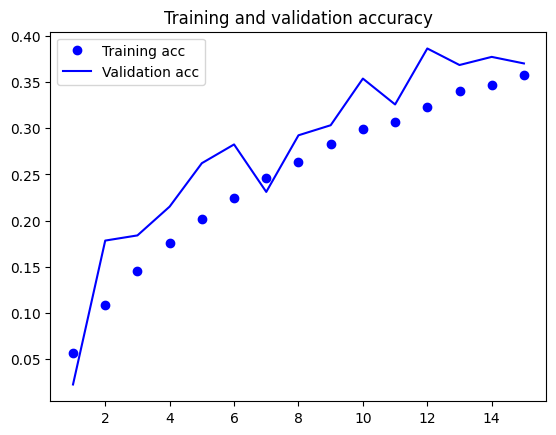

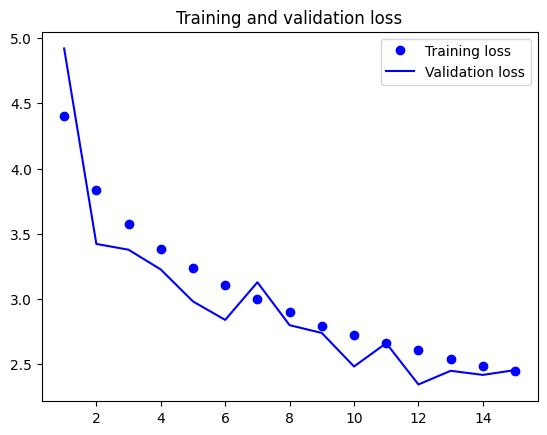

In [15]:
# Визуализация процесса обучения
training_plot(history1)

In [16]:
scores = model.evaluate(X_test, y_test_ohe)
print(f'accuracy on test set: {model.metrics_names[1]} of {scores[1]*100}')

313/313 [==============================] - 13s 40ms/step - loss: 2.4199 - accuracy: 0.3711
accuracy on test set: accuracy of 37.11000084877014


### Используем Transfer Learning

In [17]:

from tensorflow.keras.applications import ResNet50
resnet_model = ResNet50(weights='imagenet', include_top = False, input_shape = (32, 32, 3))

x = resnet_model.output
x = Flatten()(x)
x = Dense(120, activation = 'relu')(x)
predictions = Dense(units =100, activation='softmax', kernel_initializer = 'random_uniform')(x)

models = Model(inputs = resnet_model.input, outputs = predictions)

# Замораживание слоев базовой модели
for layer in resnet_model.layers:
    layer.trainable=False
    

In [18]:
models.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


In [19]:
# Тренировка модели
import time
training_start = time.time()

history2 = models.fit(aug.flow(X_train,y_train_ohe, batch_size=20),
          epochs=50,validation_data=(X_val,y_val),callbacks=callbacks)
training_stop = time.time()
training_time = training_stop - training_start
print(f"Training time: {training_time}")

Epoch 1/50
2000/2000 [==============================] - ETA: 0s - loss: 4.6072 - accuracy: 0.0089
Epoch 1: val_accuracy did not improve from 0.38640
2000/2000 [==============================] - 179s 87ms/step - loss: 4.6072 - accuracy: 0.0089 - val_loss: 4.6068 - val_accuracy: 0.0084 - lr: 0.0010
Epoch 2/50
2000/2000 [==============================] - ETA: 0s - loss: 4.6059 - accuracy: 0.0091
Epoch 2: val_accuracy did not improve from 0.38640
2000/2000 [==============================] - 247s 124ms/step - loss: 4.6059 - accuracy: 0.0091 - val_loss: 4.6075 - val_accuracy: 0.0084 - lr: 0.0010
Epoch 3/50
2000/2000 [==============================] - ETA: 0s - loss: 4.6059 - accuracy: 0.0092
Epoch 3: val_accuracy did not improve from 0.38640
2000/2000 [==============================] - 275s 137ms/step - loss: 4.6059 - accuracy: 0.0092 - val_loss: 4.6077 - val_accuracy: 0.0077 - lr: 0.0010
Epoch 4/50
2000/2000 [==============================] - ETA: 0s - loss: 4.6058 - accuracy: 0.0098
Epoch 

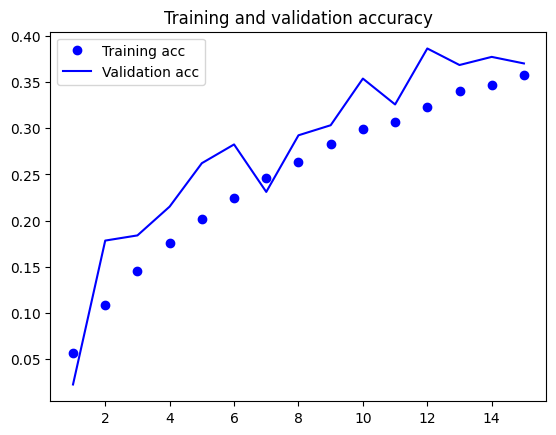

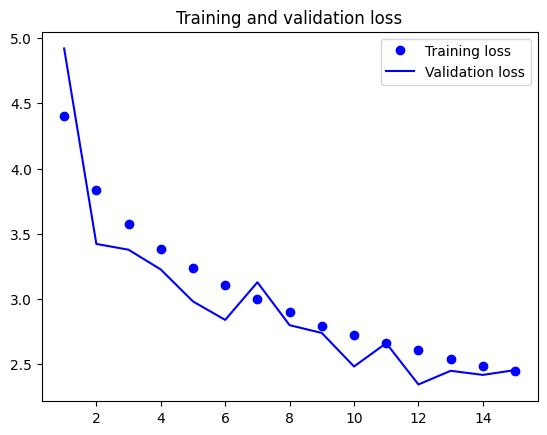

In [20]:
# Visualize training process
training_plot(history2)

In [22]:
scores = models.evaluate(X_test, y_test_ohe)
print(f'accuracy on test set: {models.metrics_names[1]} of {scores[1]*100}')

313/313 [==============================] - 44s 140ms/step - loss: 4.6055 - accuracy: 0.0100
accuracy on test set: accuracy of 0.9999999776482582


In [23]:
resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 38, 38, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 16, 16, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 16, 16, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [25]:
#Попробуем обучить не только последний fully connected слой, но и несколько предпоследних

layers_to_unfreeze = 5

# Выключаем подсчет градиентов для слоев, которые не будем обучать

for layer in resnet_model.layers[:-layers_to_unfreeze]:
    layer.trainable=False
    

In [26]:
models.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [27]:
# Тренировка модели
import time
training_start = time.time()

history3 = models.fit(aug.flow(X_train,y_train_ohe, batch_size=20),
          epochs=50,validation_data=(X_val,y_val),callbacks=callbacks)
training_stop = time.time()
training_time = training_stop - training_start
print(f"Training time: {training_time}")

Epoch 1/50
2000/2000 [==============================] - ETA: 0s - loss: 4.6059 - accuracy: 0.0096
Epoch 1: val_accuracy did not improve from 0.38640
2000/2000 [==============================] - 252s 122ms/step - loss: 4.6059 - accuracy: 0.0096 - val_loss: 4.6080 - val_accuracy: 0.0077 - lr: 0.0010
Epoch 2/50
2000/2000 [==============================] - ETA: 0s - loss: 4.6058 - accuracy: 0.0094
Epoch 2: val_accuracy did not improve from 0.38640
2000/2000 [==============================] - 256s 128ms/step - loss: 4.6058 - accuracy: 0.0094 - val_loss: 4.6079 - val_accuracy: 0.0077 - lr: 0.0010
Epoch 3/50
2000/2000 [==============================] - ETA: 0s - loss: 4.6059 - accuracy: 0.0096
Epoch 3: val_accuracy did not improve from 0.38640
2000/2000 [==============================] - 246s 123ms/step - loss: 4.6059 - accuracy: 0.0096 - val_loss: 4.6080 - val_accuracy: 0.0083 - lr: 0.0010
Epoch 4/50
2000/2000 [==============================] - ETA: 0s - loss: 4.6058 - accuracy: 0.0093
Epoch

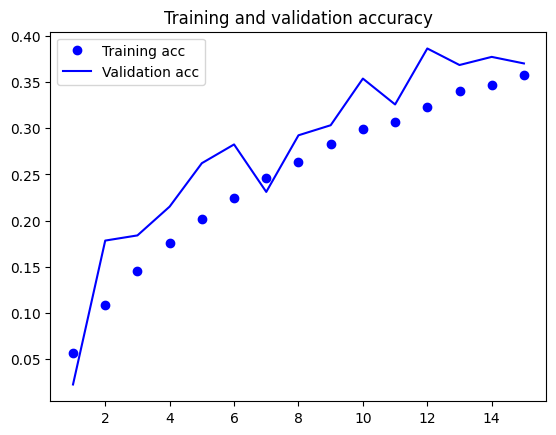

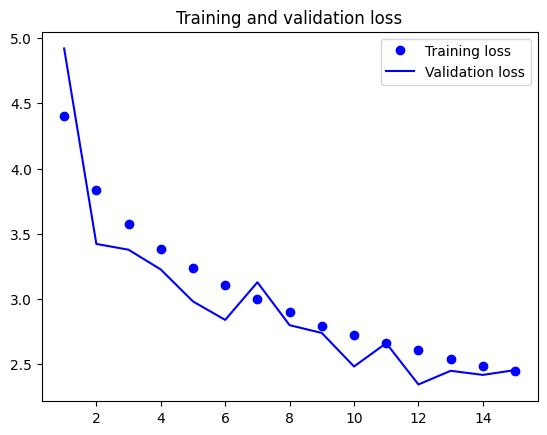

In [28]:
training_plot(history3)

In [29]:
scores = models.evaluate(X_test, y_test_ohe)
print(f'accuracy on test set: {models.metrics_names[1]} of {scores[1]*100}')

313/313 [==============================] - 37s 117ms/step - loss: 4.6055 - accuracy: 0.0100
accuracy on test set: accuracy of 0.9999999776482582
